## Spark cluster intro Air quality examples

### Initialization
Create and attach cluster created in EMR. 

The important configuration options:
 - Amazon EMR version: emr-7.1.0
 - Installed applications: JupyterHub 1.5.0
 - Logs in Amazon S3: disabled
 - Service role for Amazon EMR: EMR_DefaultRole 
 - EC2 instance profile: EMR_EC2_DefaultRole
 - EC2 security groups (firewall): open ports 9443, 18080
 
Login: jovyan, password: jupyter

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
spark = SparkSession.builder.getOrCreate()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
5,application_1730905672505_0006,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6,application_1730905672505_0007,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6,application_1730905672505_0007,pyspark,idle,Link,Link,None,✔


In [3]:
# run once per session to install additional packages
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1730905672505_0007/container_1730905672505_0007_01_000001/tmp/spark-fcc58d45-b46e-42b4-876c-c1246fd1f35a
    Can't uninstall 'python-dateutil'. No files were found to uninstall.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.


In [4]:
from pyspark.sql.functions import col, mean
import matplotlib.pyplot as plt
import pandas as pd
import time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Reading data from AWS S3

Now we can read a small sample of data:

In [5]:
start = time.time()

# wczytanie danych z plików CSV, które są skompresowane i znajdują się w lokalizacji w Amazon 3 
smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=10*/year=2022/month=05/*.csv.gz")

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

321.49365973472595

In [6]:
# Further queries on smog_df will run much faster when we cache this data set in memory
smog_df.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[location_id: string, sensors_id: string, location: string, datetime: string, lat: string, lon: string, parameter: string, units: string, value: string]

In [7]:
start = time.time()

# oblicza liczbę wierszy w smog_df
print(smog_df.count())
end = time.time()
print(end - start)

In [8]:
smog_df.printSchema()

In [7]:
smog_df = smog_df.withColumn("value", smog_df.value.cast('double'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:

smog_df.printSchema()

### Simple queries

In [11]:
smog_df.limit(10).show()

In [12]:
smog_df.select('parameter').distinct().show()

In [8]:
from pyspark.sql.functions import col, asc, desc, max

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Some more interesting statistics

In [14]:
start = time.time()
max_pm10 = smog_df.filter(col('parameter')=='pm10')\
            .filter(col('value')>0.0)\
            .groupby('location').agg(max('value').alias('max_pm10'))\
            .sort(desc('max_pm10'))

max_pm10.limit(100).show(truncate=False)
end = time.time()
print(end - start)

In [15]:
smog_df.filter(col('location').contains('Krak')).select('location').distinct().show(truncate=False)

In [16]:
max_pm10.printSchema()

In [17]:
plt.figure()
max_pm10.limit(10).toPandas().plot.barh(x='location')

In [18]:
# On EMR we need this magic to show the plot
%matplot plt

## Zadania

### Zad 1

 Znajdź miasta w Polsce, w których średnie stężenie pyłu “pm25” było niższe niż maksymalne stężenie w Berlinie (w całym badanym okresie). Obliczenia wykonaj dla danych z kilku dni. Wyniki posortuj malejąco po stężeniu pm25.

In [126]:
start = time.time()

# od 3 maja do 9 maja
berlin_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=4582/year=2022/month=05/location-4582-2022050[3-9].csv.gz")\

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.5156731605529785

In [127]:
berlin_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+------------+--------------------+---------+---------+---------+-----+-----+
|location_id|sensors_id|    location|            datetime|      lat|      lon|parameter|units|value|
+-----------+----------+------------+--------------------+---------+---------+---------+-----+-----+
|       4582|     11363|DEBE032-4582|2022-05-03T02:00:...|52.473192|13.225144|     pm10|µg/m³|18.37|
|       4582|     11363|DEBE032-4582|2022-05-03T03:00:...|52.473192|13.225144|     pm10|µg/m³|18.31|
|       4582|     11363|DEBE032-4582|2022-05-03T04:00:...|52.473192|13.225144|     pm10|µg/m³|19.77|
|       4582|     11363|DEBE032-4582|2022-05-03T05:00:...|52.473192|13.225144|     pm10|µg/m³| 19.7|
|       4582|   1300113|DEBE032-4582|2022-05-03T02:00:...|52.473192|13.225144|     pm25|µg/m³|12.31|
|       4582|   1300113|DEBE032-4582|2022-05-03T03:00:...|52.473192|13.225144|     pm25|µg/m³|12.84|
|       4582|   1300113|DEBE032-4582|2022-05-03T04:00:...|52.473192|13.225144|     pm25|µg/

In [128]:
berlin_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location_id: string (nullable = true)
 |-- sensors_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: string (nullable = true)

In [129]:
berlin_df = berlin_df.withColumn("value", berlin_df.value.cast('double'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [130]:
berlin_df.filter(col('parameter')=="pm25").select('datetime', 'parameter', 'value').distinct().sort(desc('datetime')).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+---------+-----+
|datetime                 |parameter|value|
+-------------------------+---------+-----+
|2022-05-09T04:00:00+02:00|pm25     |7.31 |
|2022-05-09T03:00:00+02:00|pm25     |6.85 |
|2022-05-09T02:00:00+02:00|pm25     |6.7  |
|2022-05-07T04:00:00+02:00|pm25     |12.61|
|2022-05-07T03:00:00+02:00|pm25     |11.51|
|2022-05-07T02:00:00+02:00|pm25     |10.2 |
|2022-05-05T04:00:00+02:00|pm25     |11.27|
|2022-05-05T03:00:00+02:00|pm25     |14.01|
|2022-05-05T02:00:00+02:00|pm25     |13.42|
|2022-05-03T05:00:00+02:00|pm25     |13.71|
|2022-05-03T04:00:00+02:00|pm25     |13.6 |
|2022-05-03T03:00:00+02:00|pm25     |12.84|
|2022-05-03T02:00:00+02:00|pm25     |12.31|
+-------------------------+---------+-----+

In [131]:
from pyspark.sql import functions as F

start = time.time()
max_pm25_berlin = berlin_df.filter(col('parameter')=="pm25").select(F.max("value")).collect()[0][0]

print("Max pm25 for Berlin: ", max_pm25_berlin)
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Max pm25 for Berlin:  14.01
0.24452805519104004

In [132]:
smog_df = smog_df.withColumn("lon", smog_df.lon.cast('double'))
smog_df = smog_df.withColumn("lat", smog_df.lat.cast('double'))

smog_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location_id: string (nullable = true)
 |-- sensors_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: double (nullable = true)

In [133]:
# filtrowanie dł. i szer. geogr.
poland_df = smog_df.filter(
    (smog_df["lat"] >= 49) & (smog_df["lat"] <= 55) &
    (smog_df["lon"] >= 14) & (smog_df["lat"] >= 24)
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [134]:
# filtrowanie dat
poland_df = poland_df.filter(F.col("datetime").rlike(r"2022-05-0[3-9]T"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [135]:
poland_df = poland_df.withColumn("city", F.split(F.col("location"), ",")[0])

poland_df.limit(5).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+----------------+
|location_id|sensors_id|            location|            datetime|      lat|      lon|parameter|units|  value|            city|
+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+----------------+
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-05T01:00:...|50.349608|18.236575|     pm10|µg/m³|33.6813|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-05T02:00:...|50.349608|18.236575|     pm10|µg/m³|35.8368|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-05T03:00:...|50.349608|18.236575|     pm10|µg/m³|34.8195|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-05T04:00:...|50.349608|18.236575|     pm10|µg/m³|35.1892|Kędzierzyn-Koźle|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-05T05:00:...|50.349608|18.236575|     pm10|µg/m³|35

In [136]:
start = time.time()
poland_agg = poland_df\
            .filter(col('parameter')=='pm25')\
            .groupby('city')\
            .agg(F.avg('value').alias('avg_pm25'))\
            .select("city", "avg_pm25")\
            .filter(col('avg_pm25')<max_pm25_berlin)\
            .sort(desc('avg_pm25'))

poland_agg.limit(100).show(truncate=False)
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------+
|city           |avg_pm25          |
+---------------+------------------+
|Kielce         |13.091894736842105|
|Siedlce        |12.760421052631582|
|Żyrardów       |12.690947368421053|
|Gdańsk         |12.363646312056737|
|Augustów       |11.836842105263155|
|Poznań         |11.778208631578948|
|Białystok      |11.547368421052632|
|Gdynia         |11.390038829787231|
|Warszawa       |11.249865470852015|
|Ostróda        |11.021867142857143|
|Kutno          |10.74736842105263 |
|Przemyśl       |10.543248315789473|
|Grajewo        |8.819999999999999 |
|Elbląg         |8.813812105263157 |
|Płock          |8.569157894736843 |
| Olsztyn       |7.602771473684211 |
|Guty Duże-10570|6.146526315789474 |
|Borsukowizna   |3.866315789473684 |
+---------------+------------------+

2.177856683731079

### Zad 2

Dla danych z wybranych kilku dni przedstaw w ujęciu godzinowym (wybierz czas UTC) najwyższe zanotowane stężenie pm10 w poszczególnych miastach z całego zbioru danych. Wyniki posortuj po rosnąco datach.

In [137]:
# wybór czasu UTC (+02:00)
all_locations = smog_df.filter(col('datetime').contains('+02:00'))

# wybór dni od 3 do 9 maja
all_locations = all_locations.filter(F.col("datetime").rlike(r"2022-05-0[3-9]T"))

# dodanie kolumny miasto
all_locations = all_locations.withColumn("city", F.split(F.col("location"), ",")[0])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [138]:
grouped2 = all_locations\
    .filter(col("parameter") == "pm10")\
    .groupby("datetime", "city")\
    .agg(F.max("value").alias("max_pm10"))\
    .select("datetime", "city", "max_pm10")\
    .sort(asc("datetime"))


grouped2.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------+
|            datetime|                city| max_pm10|
+--------------------+--------------------+---------+
|2022-05-03T00:00:...|      Minnesundvegen| 3.435499|
|2022-05-03T00:00:...|       Alnabru-10495|    15.07|
|2022-05-03T00:00:...|                Rv 4| 4.208923|
|2022-05-03T00:00:...|      Furulund-10562|47.823817|
|2022-05-03T00:00:...|       Solheim-10557|35.322361|
|2022-05-03T00:00:...|     E6-Tiller-10563|  6.57147|
|2022-05-03T00:00:...|   Bankplassen-10880| 5.113611|
|2022-05-03T00:00:...|Omkjøringsvegen-1...|   15.246|
|2022-05-03T00:00:...|Bjørndalssletta-1...| 4.009861|
|2022-05-03T00:00:...|Lillehammer barne...| 5.644444|
|2022-05-03T00:00:...|     Elgeseter-10829|15.059702|
|2022-05-03T00:00:...|E6 Alna senter-10608| 5.584928|
|2022-05-03T00:00:...|        Våland-10507|10.610342|
|2022-05-03T00:00:...|Nedre Langgate-10492| 3.724003|
|2022-05-03T00:00:...|         Rådal-10546| 9.126392|
|2022-05-03T00:00:...| Schan

In [139]:
# sprawdzenie czy jest w ujęciu godzinowym
grouped2.select("datetime").distinct().sort(asc("datetime")).show(50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            datetime|
+--------------------+
|2022-05-03T00:00:...|
|2022-05-03T01:00:...|
|2022-05-03T02:00:...|
|2022-05-03T03:00:...|
|2022-05-03T04:00:...|
|2022-05-03T05:00:...|
|2022-05-03T06:00:...|
|2022-05-03T07:00:...|
|2022-05-03T08:00:...|
|2022-05-03T09:00:...|
|2022-05-03T10:00:...|
|2022-05-03T11:00:...|
|2022-05-03T12:00:...|
|2022-05-03T13:00:...|
|2022-05-03T14:00:...|
|2022-05-03T15:00:...|
|2022-05-03T16:00:...|
|2022-05-03T17:00:...|
|2022-05-03T18:00:...|
|2022-05-03T19:00:...|
|2022-05-03T20:00:...|
|2022-05-03T21:00:...|
|2022-05-03T22:00:...|
|2022-05-03T23:00:...|
|2022-05-04T00:00:...|
|2022-05-04T01:00:...|
|2022-05-04T02:00:...|
|2022-05-04T03:00:...|
|2022-05-04T04:00:...|
|2022-05-04T05:00:...|
|2022-05-04T06:00:...|
|2022-05-04T07:00:...|
|2022-05-04T08:00:...|
|2022-05-04T09:00:...|
|2022-05-04T10:00:...|
|2022-05-04T11:00:...|
|2022-05-04T12:00:...|
|2022-05-04T13:00:...|
|2022-05-04T14:00:...|
|2022-05-04T15:00:...|
|2022-05-04

### Zad 3

Znajdź ranking miast w Europie pod względem średniego zanieczyszczenia liczonego dla N najwyższych pomiarów pod względem “pm25” dla danych z kilku dni. 

In [140]:
# filtrowanie lon i lat
europe_df = smog_df.filter(
    (F.col("lat") >= 35.0) & (F.col("lat") <= 70.0) & 
    (F.col("lon") >= -25.0) & (F.col("lon") <= 45.0)
)

# wybór dni od 3 do 9 maja
europe_df = europe_df.filter(F.col("datetime").rlike(r"2022-05-0[3-9]T"))

# dodanie kolumny miasto
europe_df = europe_df.withColumn("city", F.split(F.col("location"), ",")[0])

# filtrowanie pm25
europe_df = europe_df.filter(col("parameter") == "pm25")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [141]:
from pyspark.sql import Window

# tworzy funkcję okna, do sortowania wartości w obrębie grupy
window = Window.partitionBy("city").orderBy(F.desc("value"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [142]:
# dodanie kolumny z rangą
ranked_df = europe_df.withColumn("rank", F.row_number().over(window))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [143]:
N = 5

# filtracja N najwyższych pomiarów
top_n = ranked_df.filter(
    F.col("rank") <= N
)

top_n.select("city", "value", "rank").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+----+
|                city|  value|rank|
+--------------------+-------+----+
|             Olsztyn|34.0907|   1|
|             Olsztyn| 17.761|   2|
|             Olsztyn|17.7558|   3|
|             Olsztyn|15.3028|   4|
|             Olsztyn|15.1081|   5|
|       Alnabru-10495|  33.67|   1|
|       Alnabru-10495|  22.47|   2|
|       Alnabru-10495|  15.48|   3|
|       Alnabru-10495|  15.27|   4|
|       Alnabru-10495|  14.01|   5|
|Amsterdam-Einstei...|   27.5|   1|
|Amsterdam-Einstei...|   23.6|   2|
|Amsterdam-Einstei...|   23.5|   3|
|Amsterdam-Einstei...|   18.2|   4|
|Amsterdam-Einstei...|   12.1|   5|
|Amsterdam-Hoogtij...|   30.8|   1|
|Amsterdam-Hoogtij...|   26.5|   2|
|Amsterdam-Hoogtij...|   21.0|   3|
|Amsterdam-Hoogtij...|   19.2|   4|
|Amsterdam-Hoogtij...|   17.7|   5|
+--------------------+-------+----+
only showing top 20 rows

In [144]:
top_n\
.groupby('city')\
.agg(F.avg("value").alias("avg_pm25"))\
.sort(desc("avg_pm25"))\
.show(50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|                city|          avg_pm25|
+--------------------+------------------+
|            Radomsko|              88.0|
|              Otwock|            74.386|
|        Starachowice| 69.28599999999999|
|               Radom|            52.336|
|            Racibórz| 51.07690000000001|
|              Zamość|50.779999999999994|
|  Goczałkowice Zdrój|          50.63636|
|            Katowice|49.747159999999994|
|             Rzeszów|          48.24766|
|               Opole|          48.14736|
|              Dębica|          46.74238|
|            Augustów|              46.4|
|              Kalisz|45.401979999999995|
|              Lublin|             44.64|
|            Warszawa|            43.894|
|        Jelenia Góra|          43.41078|
|              Kraków|           43.2857|
|             Siedlce|42.839999999999996|
|              Tarnów|           42.8144|
|              Gdańsk|          41.12148|
|           Białystok|            

### Zad 4

Zwizualizuj na mapie średnie zanieczyszczenie w danym kraju dla wybranych kilku dni względem czasu (mapa + slider czasu albo zbiór klatek i animacja) dla wybranych państw.

In [26]:
# wybór dni
countries_avg = smog_df.filter(F.col("datetime").rlike(r"2022-05-0[3-9]T"))


# wybór dni
countries_avg = countries_avg.filter(F.col("parameter") == "pm10")

# dodanie kolumny daty
countries_avg = countries_avg.withColumn("date", F.split(F.col("datetime"), "T")[0])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
countries_avg.select("datetime", "date").limit(5).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+
|            datetime|      date|
+--------------------+----------+
|2022-05-05T01:00:...|2022-05-05|
|2022-05-05T02:00:...|2022-05-05|
|2022-05-05T03:00:...|2022-05-05|
|2022-05-05T04:00:...|2022-05-05|
|2022-05-05T05:00:...|2022-05-05|
+--------------------+----------+

In [28]:
# Dodanie kolumny "country" na podstawie zakresów współrzędnych
countries_avg = countries_avg.withColumn(
    "country",
    F.when((F.col("lat") >= 49.0) & (F.col("lat") <= 55.0) &
           (F.col("lon") >= 14.0) & (F.col("lon") <= 24.0), "Poland")
    .when((F.col("lat") >= 58.0) & (F.col("lat") <= 71.0) &
          (F.col("lon") >= 5.0) & (F.col("lon") <= 31.0), "Norway")
    .when((F.col("lat") >= 55.0) & (F.col("lat") <= 69.0) &
          (F.col("lon") >= 11.0) & (F.col("lon") <= 24.0), "Sweden")
    .otherwise("Other")
)


countries_avg = countries_avg.filter(col("country") != "Other").select("date", "country", "value")

countries_avg.limit(5).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------+-------+
|      date|country|  value|
+----------+-------+-------+
|2022-05-05| Poland|33.6813|
|2022-05-05| Poland|35.8368|
|2022-05-05| Poland|34.8195|
|2022-05-05| Poland|35.1892|
|2022-05-05| Poland|35.0769|
+----------+-------+-------+

In [29]:
countries_avg.select("country").distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+
|country|
+-------+
| Poland|
| Norway|
| Sweden|
+-------+

In [30]:
countries_avg = countries_avg\
    .groupby("country", "date")\
    .agg(F.avg("value").alias("avg_pm10"))

countries_avg.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+------------------+
|country|      date|          avg_pm10|
+-------+----------+------------------+
| Poland|2022-05-09|16.428382379182157|
| Poland|2022-05-04|26.220980999999995|
| Poland|2022-05-08| 40.31083676470589|
| Poland|2022-05-05|26.736254714467005|
| Poland|2022-05-03|  27.2068877470107|
| Poland|2022-05-06| 27.42870588235294|
| Poland|2022-05-07|26.042149744229572|
| Norway|2022-05-09|18.784037172484606|
| Norway|2022-05-04|20.914759248175184|
| Norway|2022-05-05|18.633689332653056|
| Norway|2022-05-03|15.024223815134098|
| Norway|2022-05-06|20.000957269035535|
| Norway|2022-05-08| 9.966320628450106|
| Sweden|2022-05-06|          18.87755|
| Sweden|2022-05-05|22.796976818181815|
| Sweden|2022-05-03|23.364887727272727|
| Sweden|2022-05-09|17.260790909090908|
| Sweden|2022-05-04|         16.080535|
| Sweden|2022-05-07|14.421484772727274|
| Norway|2022-05-07| 9.456521739130435|
+-------+----------+------------------+

In [33]:
sc.install_pypi_package("ipywidgets")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.24
    Not uninstalling prompt-toolkit at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1730905672505_0007/container_1730905672505_0007_01_000001/tmp/spark-fcc58d45-b46e-42b4-876c-c1246fd1f35a
    Can't uninstall 'prompt-toolkit'. No files were found to uninstall.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires prompt-toolkit<3.0.39,>=3.0.24, but you have prompt-toolkit 3.0.48 which is incompatible.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.

In [34]:
import folium
from folium.plugins import HeatMap
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
countries_df = countries_avg.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
countries_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   country        date   avg_pm10
0   Poland  2022-05-09  16.428382
1   Poland  2022-05-04  26.220981
2   Poland  2022-05-08  40.310837
3   Poland  2022-05-05  26.736255
4   Poland  2022-05-03  27.206888
5   Poland  2022-05-06  27.428706
6   Poland  2022-05-07  26.042150
7   Norway  2022-05-09  18.784037
8   Norway  2022-05-04  20.914759
9   Norway  2022-05-05  18.633689
10  Norway  2022-05-03  15.024224
11  Norway  2022-05-06  20.000957
12  Norway  2022-05-08   9.966321
13  Sweden  2022-05-06  18.877550
14  Sweden  2022-05-05  22.796977
15  Sweden  2022-05-03  23.364888
16  Sweden  2022-05-09  17.260791
17  Sweden  2022-05-04  16.080535
18  Sweden  2022-05-07  14.421485
19  Norway  2022-05-07   9.456522

In [38]:
countries_df['date'] = pd.to_datetime(countries_df['date'])
countries_df.info()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   country   20 non-null     object        
 1   date      20 non-null     datetime64[ns]
 2   avg_pm10  20 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 608.0+ bytes

In [39]:
# środek
coordinates = {
    "Poland": [52.0, 19.0],
    "Norway": [60.0, 8.0],
    "Sweden": [63.0, 15.0]
}

# Dodanie kolumn ze współrzędną 
countries_df['latitude'] = countries_df['country'].map(lambda x: coordinates[x][0])
countries_df['longitude'] = countries_df['country'].map(lambda x: coordinates[x][1])

countries_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   country       date   avg_pm10  latitude  longitude
0   Poland 2022-05-09  16.428382      52.0       19.0
1   Poland 2022-05-04  26.220981      52.0       19.0
2   Poland 2022-05-08  40.310837      52.0       19.0
3   Poland 2022-05-05  26.736255      52.0       19.0
4   Poland 2022-05-03  27.206888      52.0       19.0
5   Poland 2022-05-06  27.428706      52.0       19.0
6   Poland 2022-05-07  26.042150      52.0       19.0
7   Norway 2022-05-09  18.784037      60.0        8.0
8   Norway 2022-05-04  20.914759      60.0        8.0
9   Norway 2022-05-05  18.633689      60.0        8.0
10  Norway 2022-05-03  15.024224      60.0        8.0
11  Norway 2022-05-06  20.000957      60.0        8.0
12  Norway 2022-05-08   9.966321      60.0        8.0
13  Sweden 2022-05-06  18.877550      63.0       15.0
14  Sweden 2022-05-05  22.796977      63.0       15.0
15  Sweden 2022-05-03  23.364888      63.0       15.0
16  Sweden 2022-05-09  17.260791      63.0       15.0
17  Sweden 2022-05-04  16.08

In [67]:
sc.install_pypi_package("geopandas")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
import geopandas as gpd

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

world = gpd.read_file(url)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
world.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        featurecla  ...                                           geometry
0  Admin-0 country  ...  MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ...
1  Admin-0 country  ...  POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3...
2  Admin-0 country  ...  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3  Admin-0 country  ...  MULTIPOLYGON (((-122.84 49, -122.97421 49.0025...
4  Admin-0 country  ...  MULTIPOLYGON (((-122.84 49, -120 49, -117.0312...

[5 rows x 169 columns]

In [88]:
print(list(world.columns))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM0_A3_KO', 'ADM0_A3_VN', 'ADM0_A3_TR', 'AD

In [99]:
# Wybierz tylko kolumny 'NAME' i 'geometry' oraz zmień nazwę kolumny 'NAME' na 'name'
selected_countries = world[['NAME', 'geometry']].rename(columns={"NAME": "name"})

# Filtrowanie krajów: Polska, Szwecja i Norwegia
selected_countries = selected_countries[selected_countries['name'].isin(["Poland", "Sweden", "Norway"])]


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [100]:
selected_countries.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       name                                           geometry
21   Norway  MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...
110  Sweden  POLYGON ((11.02737 58.85615, 11.46827 59.43239...
113  Poland  POLYGON ((23.48413 53.9125, 23.52754 53.47012,...

In [101]:

# Połącz granice z danymi o zanieczyszczeniu
merged = selected_countries.set_index('name').join(countries_df.set_index('country'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [123]:
merged.sort_values(by="date", inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [145]:
import matplotlib.pyplot as plt
import geopandas as gpd
import math

# unikalne daty
unique_dates = merged['date'].unique()


n_dates = len(unique_dates)
n_cols = 3  
n_rows = math.ceil(n_dates / n_cols)  # Wyliczenie liczby wierszy na podstawie liczby dat


fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.suptitle("Srednie zanieczyszczenie PM10 dla Polski, Norwegii i Szwecji", fontsize=16)


for i, date in enumerate(unique_dates):
    # Filtrowanie danych dla konkretnego dnia
    daily_data = merged[merged['date'] == date]
    
    # Określenie osi (które subploty są wierszami i kolumnami)
    ax = axes[i // n_cols, i % n_cols]
    
    # Tworzenie mapy
    daily_data.plot(column='avg_pm10', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    
    # Ustawienia tytułu i osi dla każdego subplotu
    ax.set_title(f"Data: {date}")
    ax.axis('off')

# Wyłączenie nieużywanych subplotów (jeśli liczba subplotów przekracza liczbę dat)
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

# Dostosowanie układu
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

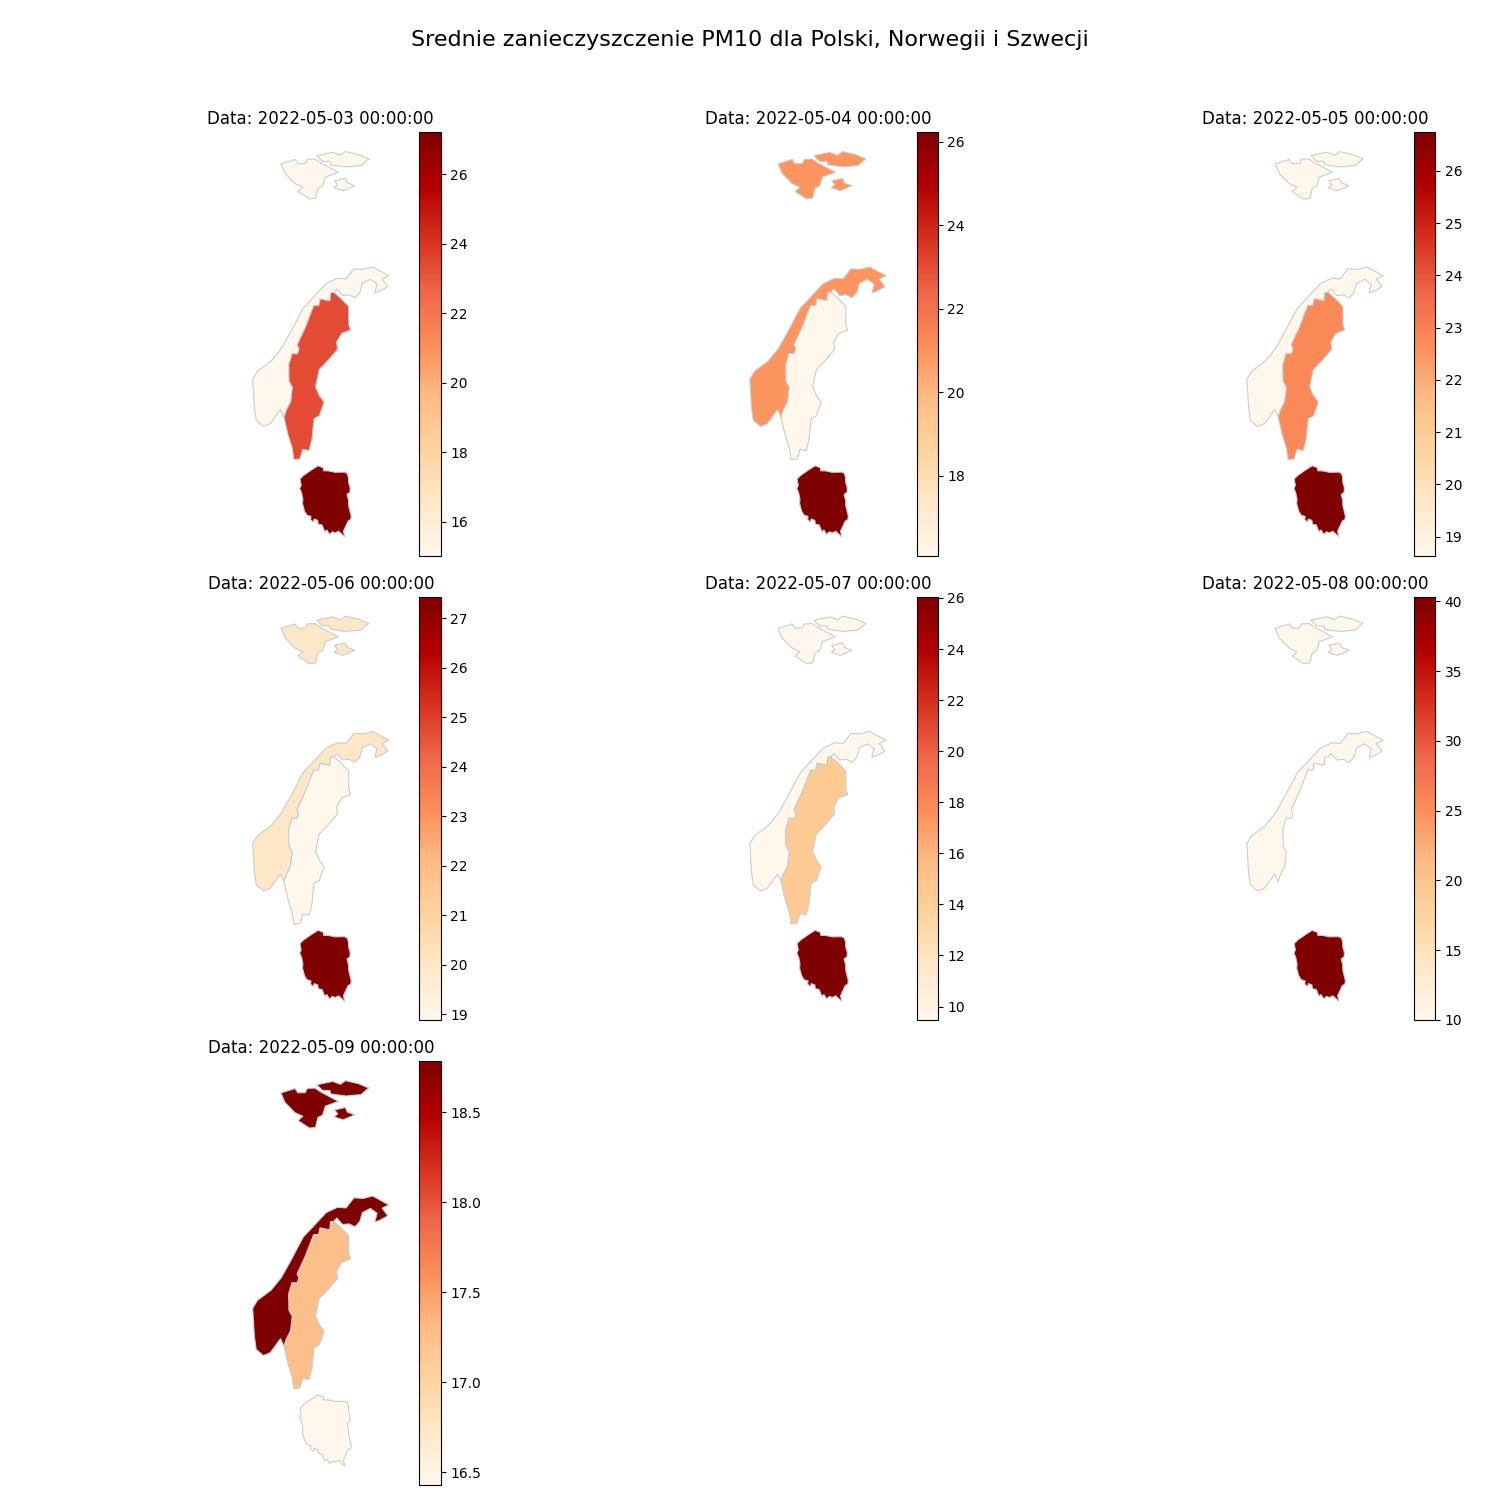

In [146]:
%matplot plt

### Zad 5

Korzystanie z klastra dla dużych danych
Proszę wykonać zadanie 1 dla danych o tak dobranym rozmiarze, żeby czas zapytania wynosił co najmniej 10 minut. Zmierzyć czas wykonania.
Zwiększyć klaster do 2, 3, 4, 5, 6, 7 instancji workerów i zmierzyć czasy wykonania.
Narysować wykresy czasu, przyspieszenia, efektywności (time, speedup, efficiency).

In [147]:
start = time.time()

# wczytanie danych z plików CSV, które są skompresowane i znajdują się w lokalizacji w Amazon 3 
smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=1*/year=2022/month=05/*.csv.gz")

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

935.1067399978638

In [148]:
start = time.time()
smog_df = smog_df.withColumn("value", smog_df.value.cast('double'))
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.005292177200317383

In [149]:
# # Brak cachowania
# smog_df.cache()

start = time.time()
smog_filtered_max_value = smog_df.filter(col('location').contains("Krak")).select(F.max("value")).collect()[0][0]

smog_df = smog_df.withColumn("city", F.split(F.col("location"), ",")[0])

lower_than_kr = smog_df\
            .groupby('city')\
            .agg(F.avg('value').alias('avg_value'))\
            .select("city", "avg_value")\
            .filter(col('avg_value')<smog_filtered_max_value)\
            .sort(desc('avg_value'))

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

735.2789657115936

Po zmianie na 2 instancje

In [150]:
start = time.time()
smog_filtered_max_value = smog_df.filter(col('location').contains("Krak")).select(F.max("value")).collect()[0][0]

lower_than_kr = smog_df\
            .groupby('city')\
            .agg(F.avg('value').alias('avg_value'))\
            .select("city", "avg_value")\
            .filter(col('avg_value')<smog_filtered_max_value)\
            .sort(desc('avg_value'))

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

247.86009216308594

Po zmianie na 3 instancje

In [151]:
start = time.time()
smog_filtered_max_value = smog_df.filter(col('location').contains("Krak")).select(F.max("value")).collect()[0][0]

lower_than_kr = smog_df\
            .groupby('city')\
            .agg(F.avg('value').alias('avg_value'))\
            .select("city", "avg_value")\
            .filter(col('avg_value')<smog_filtered_max_value)\
            .sort(desc('avg_value'))

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

148.09281420707703

Po zmianie na 4 instancje

In [152]:
start = time.time()
smog_filtered_max_value = smog_df.filter(col('location').contains("Krak")).select(F.max("value")).collect()[0][0]

lower_than_kr = smog_df\
            .groupby('city')\
            .agg(F.avg('value').alias('avg_value'))\
            .select("city", "avg_value")\
            .filter(col('avg_value')<smog_filtered_max_value)\
            .sort(desc('avg_value'))

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

155.86704993247986

Po zmianie na 5 instancji

In [153]:
start = time.time()
smog_filtered_max_value = smog_df.filter(col('location').contains("Krak")).select(F.max("value")).collect()[0][0]

lower_than_kr = smog_df\
            .groupby('city')\
            .agg(F.avg('value').alias('avg_value'))\
            .select("city", "avg_value")\
            .filter(col('avg_value')<smog_filtered_max_value)\
            .sort(desc('avg_value'))

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

90.82849264144897

Po zmianie na 6 instancji

In [154]:
start = time.time()
smog_filtered_max_value = smog_df.filter(col('location').contains("Krak")).select(F.max("value")).collect()[0][0]

lower_than_kr = smog_df\
            .groupby('city')\
            .agg(F.avg('value').alias('avg_value'))\
            .select("city", "avg_value")\
            .filter(col('avg_value')<smog_filtered_max_value)\
            .sort(desc('avg_value'))

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

91.28491568565369

Po zmianie na 7 instancji

In [155]:
start = time.time()
smog_filtered_max_value = smog_df.filter(col('location').contains("Krak")).select(F.max("value")).collect()[0][0]

lower_than_kr = smog_df\
            .groupby('city')\
            .agg(F.avg('value').alias('avg_value'))\
            .select("city", "avg_value")\
            .filter(col('avg_value')<smog_filtered_max_value)\
            .sort(desc('avg_value'))

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

76.55273914337158

In [156]:
exec_times = [735.28, 247.86, 148.09, 155.86, 90.83, 91.28, 76.55]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [159]:

x_values = list(range(1, len(exec_times) + 1))

plt.figure(figsize=(8, 5))
plt.plot(x_values, exec_times, 'o--', color='b')  # 'o' to kropka, '--' to linia przerywana

plt.xlabel("Liczba instancji workerów")
plt.ylabel("Czas wykonania (s)")

plt.title("Czas wykonania w zaleznosci od liczby instancji workerow")

plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

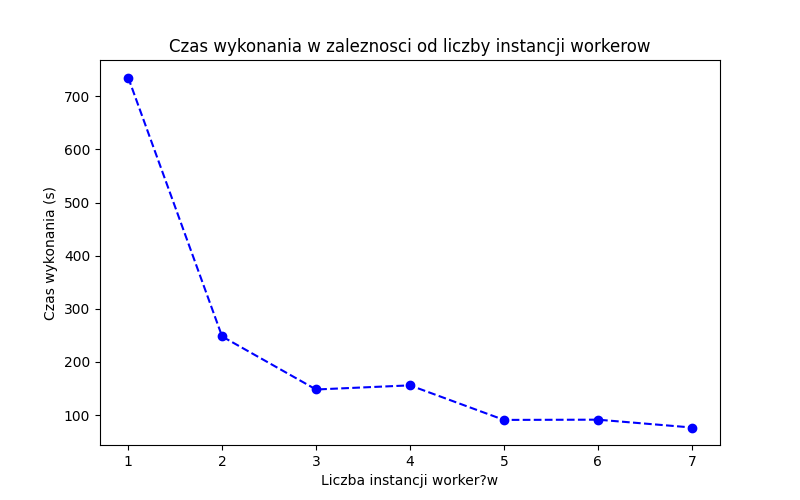

In [160]:
%matplot plt